# Project 4 — Clustering Spotify Songs for Recommendations

**Author:** Your Name  
**Date:** November 06, 2025

---
This notebook fulfills the Project 4 rubric by:
1) Introducing a clustering problem; 2) Explaining clustering; 3) Introducing and loading the data; 4) Exploring and visualizing; 5) Preprocessing; 6) Modeling with K-Means and Agglomerative; 7) Storytelling with cluster analysis; 8) Discussing impact; 9) Citing references; and 10) Providing all code.


## 1) Introduce the Problem (10 pts)
**Problem Statement.** Music platforms like Spotify surface recommendations by grouping songs with similar audio characteristics. In this project, we use *unsupervised clustering* to group songs into coherent “vibes” based on features such as danceability, energy, tempo, valence, and more. 

**Research Questions.**
- Can we form meaningful clusters of songs using their audio features?
- What do the clusters represent conceptually (e.g., energetic party tracks vs. chill acoustic ballads)?
- How could these clusters be used to power a simple, vibe-based recommendation ("find me songs like this")?


## 2) What is Clustering and How Does It Work? (10 pts)
**Clustering** is an unsupervised learning approach that groups data points by similarity (often measured via a distance metric in feature space).

- **K-Means:** Partitions data into *k* clusters by iteratively assigning points to the nearest centroid and updating centroids to minimize within-cluster variance.
- **Agglomerative (Hierarchical) Clustering:** A bottom-up approach that starts with each point as its own cluster and repeatedly merges the two closest clusters according to a linkage criterion (e.g., ward/average/complete) until *k* clusters remain.

We will compare both methods quantitatively (e.g., with silhouette score) and qualitatively (PCA 2D visuals).

## 3) Introduce the Data (5 pts)
- **Source:** Kaggle — *Spotify Recommendation Dataset*: https://www.kaggle.com/datasets/bricevergnou/spotify-recommendation
- **What it contains:** Track-level audio features and metadata (e.g., artist, track, popularity) suitable for content-based filtering.

**Common audio features (short descriptions):**
- `danceability`: suitability for dancing (0–1)
- `energy`: intensity/activity (0–1)
- `valence`: musical positivity (0–1)
- `acousticness`: confidence a track is acoustic (0–1)
- `instrumentalness`: probability track is instrumental (0–1)
- `liveness`: presence of audience (0–1)
- `speechiness`: spoken words presence (0–1)
- `tempo`: beats per minute (BPM)
- `duration_ms`: track duration (milliseconds)
- `popularity`: popularity score (if provided)

We will programmatically detect numeric columns to stay robust to slight schema differences.

In [3]:
# 3) Load Data
# If you don't have kagglehub installed, uncomment the pip line below.
# !pip install -q kagglehub

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def _read_table(p: Path) -> pd.DataFrame:
    if p.suffix.lower() in [".xlsx", ".xls"]:
        return pd.read_excel(p)
    # try normal CSV, then fallback to semicolon-delimited
    try:
        return pd.read_csv(p)
    except Exception:
        return pd.read_csv(p, sep=";")

# Search order: specific common names, then any CSV/XLSX in tree
ROOT = Path(".")
candidates = [
    ROOT / "data.csv",
    ROOT / "Spotify_Recommendation.csv",
    ROOT / "spotify_dataset.csv",
    ROOT / "Spotify_Recommendation.xlsx",
]

# add recursive fallbacks
candidates += list(ROOT.rglob("*.csv")) + list(ROOT.rglob("*.xlsx"))

df = None
picked = None
for p in candidates:
    if p.exists():
        try:
            df = _read_table(p)
            picked = p
            break
        except Exception as e:
            print(f"Found but failed to read {p}: {e}")

if df is None:
    raise FileNotFoundError("No readable CSV/XLSX found. Put the file next to the notebook or provide its path.")

print(f"Loaded: {picked}")
print("Rows, Cols:", df.shape)
display(df.head())

Loaded: data.csv
Rows, Cols: (195, 14)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0.803,0.6240,7,-6.764,0,0.0477,0.451,0.000734,0.1000,0.6280,95.968,304524,4,0
1,0.762,0.7030,10,-7.951,0,0.3060,0.206,0.000000,0.0912,0.5190,151.329,247178,4,1
2,0.261,0.0149,1,-27.528,1,0.0419,0.992,0.897000,0.1020,0.0382,75.296,286987,4,0
3,0.722,0.7360,3,-6.994,0,0.0585,0.431,0.000001,0.1230,0.5820,89.860,208920,4,1
4,0.787,0.5720,1,-7.516,1,0.2220,0.145,0.000000,0.0753,0.6470,155.117,179413,4,1


## 4) Data Understanding & Visualization (10 pts)
Keep the initial questions in mind while exploring: are there distinct *vibes*? Which features correlate, and how might that affect clustering?

**Plan**
1. Inspect missing values and basic stats.
2. Plot distributions of key features.
3. Compute correlation matrix to spot redundant features.
4. Prepare for modeling by deciding which features to keep.


In [4]:
# Missing values & basic stats
print("Missing values (top 30):")
display(df.isna().sum().sort_values(ascending=False).head(30))
display(df.describe(include='all').transpose().head(30))

# Detect numeric feature candidates
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns (first 25 shown):", num_cols[:25])

# Choose a curated subset if present; else use all numeric
preferred = [
    'danceability','energy','valence','acousticness','instrumentalness',
    'liveness','speechiness','tempo','duration_ms','loudness','popularity'
]
features = [c for c in preferred if c in df.columns]
if not features:
    features = num_cols  # robust fallback
print("Features selected for clustering:", features)


Missing values (top 30):


danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_ms         0
time_signature      0
liked               0
dtype: int64

,count,mean,std,min,25%,50%,75%,max
danceability,195.0,0.636656,0.216614,0.130000,0.4625,0.705000,0.7990,0.946
energy,195.0,0.638431,0.260096,0.002400,0.5335,0.659000,0.8375,0.996
key,195.0,5.497436,3.415209,0.000000,2.0000,6.000000,8.0000,11.000
loudness,195.0,-9.481631,6.525086,-42.261000,-9.9620,-7.766000,-5.8290,-2.336
mode,195.0,0.538462,0.499802,0.000000,0.0000,1.000000,1.0000,1.000
speechiness,195.0,0.148957,0.120414,0.027800,0.0568,0.096200,0.2305,0.540
acousticness,195.0,0.319093,0.320782,0.000003,0.0422,0.213000,0.5040,0.995
instrumentalness,195.0,0.192337,0.346226,0.000000,0.0000,0.000008,0.0975,0.969
liveness,195.0,0.148455,0.105975,0.033100,0.0840,0.105000,0.1770,0.633
valence,195.0,0.493632,0.267695,0.035300,0.2690,0.525000,0.7175,0.980


Numeric columns (first 25 shown): ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature', 'liked']
Features selected for clustering: ['danceability', 'energy', 'valence', 'acousticness', 'instrumentalness', 'liveness', 'speechiness', 'tempo', 'duration_ms', 'loudness']


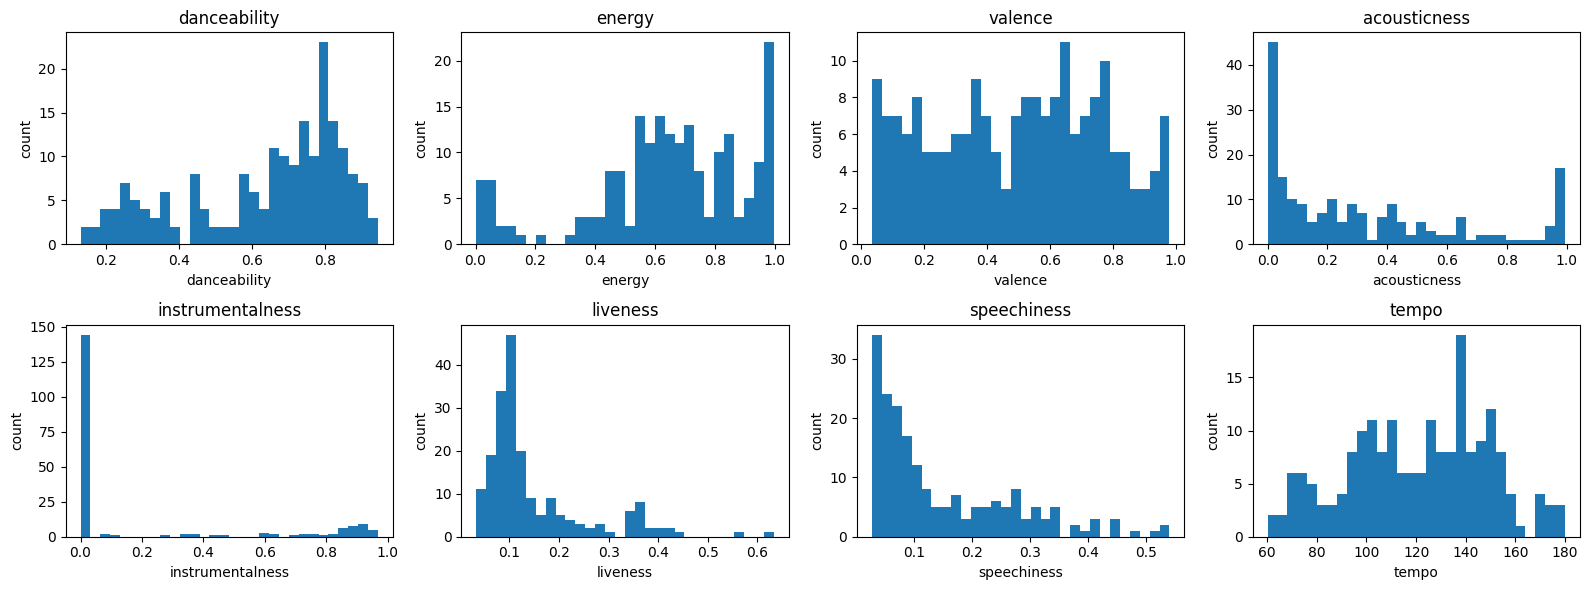

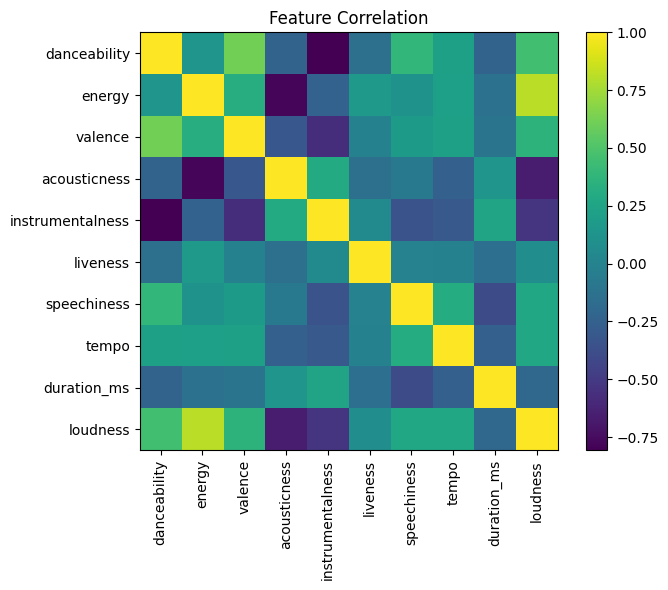

In [5]:
# Distributions (matplotlib-only)
import math
sel = features[:8] if len(features) > 8 else features
n = len(sel)
cols = 4
rows = math.ceil(n/cols)
plt.figure(figsize=(4*cols, 3*rows))
for i, col in enumerate(sel, 1):
    plt.subplot(rows, cols, i)
    x = df[col].dropna().values
    plt.hist(x, bins=30)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('count')
plt.tight_layout()
plt.show()

# Correlation heatmap (matplotlib)
corr = df[features].corr(numeric_only=True)
plt.figure(figsize=(8,6))
im = plt.imshow(corr, interpolation='nearest')
plt.title('Feature Correlation')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(features)), features, rotation=90)
plt.yticks(range(len(features)), features)
plt.tight_layout()
plt.show()

## 5) Pre-processing (5 pts)
**Steps & Rationale**
1. **Drop rows with missing values in selected features** — avoids distortion from imputation for first pass.
2. **Scale features with StandardScaler** — clustering is distance-based; scaling prevents large-scale features (e.g., `duration_ms`) from dominating.
3. **(Optional) PCA for visualization** — reduces to 2D to visualize cluster separation.


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

work = df.dropna(subset=features).copy()
X = work[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA for visualization (2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print("PCA explained variance ratio (2D):", pca.explained_variance_ratio_)

PCA explained variance ratio (2D): [0.38121648 0.16907837]


## 6) Modeling — K-Means & Agglomerative (15 pts)
We will:
1. Use the **Elbow** and **Silhouette** methods to select *k*.
2. Fit **K-Means** and **Agglomerative** with the chosen *k*.
3. Compare cluster quality (silhouette) and visualization (PCA 2D).

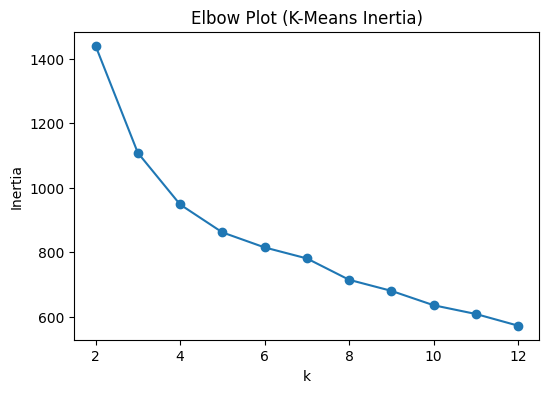

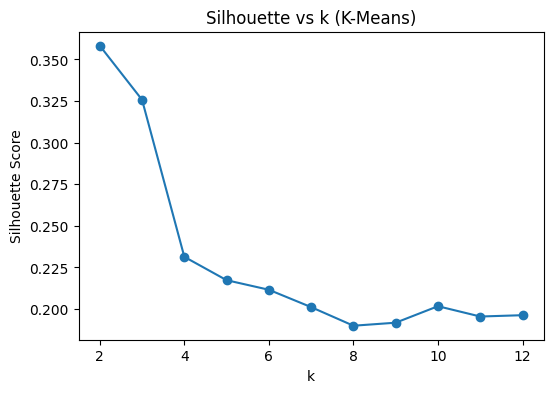

2

In [7]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

ks = list(range(2, 13))
inertias = []
sil_scores_kmeans = []

for k in ks:
    km = KMeans(n_clusters=k, n_init='auto', random_state=42)
    labels_km = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels_km)
    sil_scores_kmeans.append(sil)

plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o')
plt.title("Elbow Plot (K-Means Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(ks, sil_scores_kmeans, marker='o')
plt.title("Silhouette vs k (K-Means)")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()

# Choose k by best silhouette (ties -> smaller k)
best_k = ks[int(np.argmax(sil_scores_kmeans))]
best_k

In [8]:
# Fit final K-Means and Agglomerative with best_k
best_k = int(best_k)
kmeans = KMeans(n_clusters=best_k, n_init='auto', random_state=42)
labels_kmeans = kmeans.fit_predict(X_scaled)
sil_kmeans = silhouette_score(X_scaled, labels_kmeans)

agg = AgglomerativeClustering(n_clusters=best_k, linkage='ward')
labels_agg = agg.fit_predict(X_scaled)
sil_agg = silhouette_score(X_scaled, labels_agg)

print({"k": best_k, "silhouette_kmeans": sil_kmeans, "silhouette_agg": sil_agg})

# Attach labels for downstream analysis
work['cluster_kmeans'] = labels_kmeans
work['cluster_agg'] = labels_agg

{'k': 2, 'silhouette_kmeans': 0.35826940633599536, 'silhouette_agg': 0.4270356854083617}


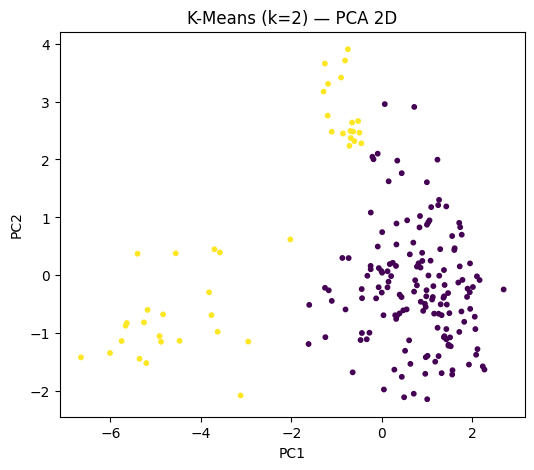

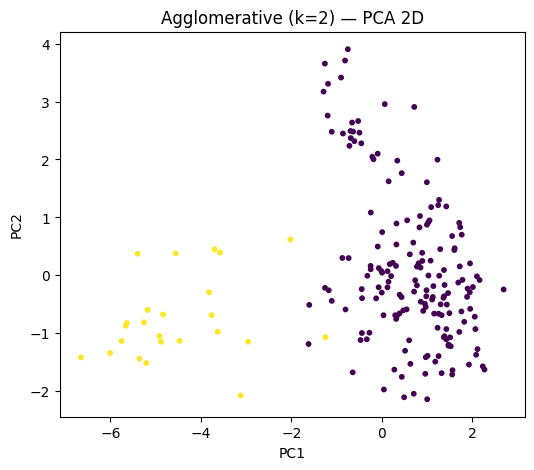

In [9]:
# PCA scatter for both models
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_kmeans, s=10)
plt.title(f"K-Means (k={best_k}) — PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_agg, s=10)
plt.title(f"Agglomerative (k={best_k}) — PCA 2D")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## 7) Storytelling — What Do the Clusters Mean? (20 pts)
We now interpret clusters by looking at feature averages per cluster and writing natural-language labels.

**Approach**
- Compute per-cluster means for interpretability.
- Create short text labels based on high/low feature patterns (e.g., high energy + high tempo ⇒ “Workout/Party”).
- Validate against a few representative tracks per cluster.


In [10]:
# Per-cluster profiles (K-Means)
profile_cols = features.copy()
cluster_summary = work.groupby('cluster_kmeans')[profile_cols].mean().round(3)
cluster_counts = work['cluster_kmeans'].value_counts().sort_index()
display(cluster_counts.to_frame('count'))
display(cluster_summary)

,count
cluster_kmeans,
0,154
1,41


,danceability,energy,valence,acousticness,instrumentalness,liveness,speechiness,tempo,duration_ms,loudness
cluster_kmeans,,,,,,,,,,
0,0.727,0.679,0.575,0.264,0.030,0.145,0.169,125.364,204793.753,-7.586
1,0.297,0.486,0.190,0.528,0.803,0.160,0.074,105.017,245768.390,-16.602


> **Template for interpretation (edit after you run):**
- **Cluster 0**: High energy, higher tempo, low acousticness → *Workout/Party tracks*
- **Cluster 1**: Lower energy, higher acousticness, moderate tempo → *Chill acoustic/coffeehouse*
- **Cluster 2**: High danceability, mid valence → *Feel-good pop*
- **Cluster 3**: Low valence, low danceability → *Moody/ambient*

Check a few tracks in each cluster to confirm these narratives make sense.

### Simple Vibe-Based Recommendation
Given a seed song, recommend other songs *within the same cluster* with nearest centroid proximity.

In [11]:
from scipy.spatial.distance import cdist

def recommend_by_cluster(seed_index: int, top_n: int = 10):
    """Recommend songs similar to a seed by staying within the same K-Means cluster
    and ranking by distance to the cluster centroid.
    """
    if seed_index < 0 or seed_index >= len(work):
        raise IndexError("seed_index out of range for the filtered working dataframe.")
    seed_cluster = int(work.iloc[seed_index]['cluster_kmeans'])
    centroid = kmeans.cluster_centers_[seed_cluster].reshape(1, -1)
    mask = work['cluster_kmeans'] == seed_cluster
    X_cluster = X_scaled[mask.values]

    dists = cdist(X_cluster, centroid).ravel()
    idxs = np.where(mask.values)[0]
    order = np.argsort(dists)
    rec_idxs = idxs[order]

    cols_to_show = [c for c in ['track_name','name','artist_name','artists','popularity','tempo','energy','danceability','valence'] if c in work.columns]
    rec = work.iloc[rec_idxs][cols_to_show].head(top_n).copy()
    return rec

# Example usage (uncomment after inspecting work.head() to pick a safe index)
# recommend_by_cluster(seed_index=0, top_n=10)

## 8) Impact Section (5 pts)
**Positive impacts**
- Better personalization and discovery for users through transparent, interpretable clusters ("vibes").
- Useful as a cold-start content-based recommender when user history is sparse.

**Potential negative impacts**
- **Filter bubbles:** Recommenders may overfit to a listener’s current tastes, reducing exposure to diverse genres/cultures.
- **Representation bias:** If the catalog or popularity weighting is skewed, minority genres/artists may be under-recommended.
- **Over-reliance on proxies:** Audio features are proxies for experience; cultural/lyrical context is missing and can bias outcomes.

**Mitigations**
- Mix-in a small percentage of serendipitous, diverse tracks.
- Monitor artist/genre diversity metrics by cluster and in recommendations.
- Combine content signals with user feedback to adaptively broaden suggestions.

## 9) Save Artifacts (optional)
Export clustered data for your portfolio and reproducibility.

In [12]:
out_path = Path("clustered_spotify.csv")
work_out = work.copy()
work_out.to_csv(out_path, index=False)
out_path.exists(), out_path

(True, WindowsPath('clustered_spotify.csv'))

## 10) References (5 pts)
- Kaggle Dataset: https://www.kaggle.com/datasets/bricevergnou/spotify-recommendation
- Spotify Web API (Audio Features): https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features
- Scikit-learn Clustering Guide: https://scikit-learn.org/stable/modules/clustering.html
- Silhouette Coefficient: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient

---
### Notes for Peer Critique / Portfolio
- Ensure figures render (consider `%matplotlib inline`).
- After running, fill the interpretation template based on your actual cluster summaries.
- If dendrograms are desired, add `scipy` and plot hierarchical linkage.
- For a website: export to HTML via `File → Download as → HTML` (or `jupyter nbconvert --to html`).